In [1]:
from pytube import YouTube
import skvideo.io
import numpy as np
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

## 下載及讀取影像資料

In [2]:
def youtube_to_array(youtube_url):
    yt = YouTube(youtube_url)
    video = [x for x in yt.get_videos() if x.extension == 'mp4' and x.resolution == '360p'][0]
    video.download('/tmp/', force_overwrite=True)
    videodata = skvideo.io.vread(u'/tmp/{}.{}'.format(video.filename, video.extension).encode('utf8'))
    return videodata

In [3]:
data1 = youtube_to_array('https://www.youtube.com/watch?v=CJ5EdyUBSSw')

In [4]:
data1.shape

(5370, 360, 640, 3)

In [5]:
data2 = youtube_to_array('https://www.youtube.com/watch?v=9hBLYLQ4MIM')

In [6]:
data2.shape

(2132, 360, 640, 3)

## 用OpenCV的MSER作斑點檢測

In [7]:
class TextDetect():
    def __init__(self, delta=10, min_area=60, max_area=300, var=0.1):
        self.mser = cv2.MSER_create(_delta=delta, _min_area=min_area, _max_area=max_area, _max_variation=var)
    
    def detect_region(self, np_array_with_rgb):
        '''找出可能的文字區域'''
        bgr = np_array_with_rgb[:, :, ::-1]
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        regions = self.mser.detectRegions(gray, None)
        return regions
    
    def region_number(self, np_array_with_rgb):
        '''計算文字區域的數量'''
        return len(self.detect_region(np_array_with_rgb))

    def plot(self, np_array_with_rgb):
        '''將文字區域填上綠色'''
        regions = self.detect_region(np_array_with_rgb)
        hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
        new_hulls = []
        for h in hulls:
            x = [item[0][0] for item in h]
            y = [item[0][1] for item in h]
            new_hulls.append(np.array([[(min(x), min(y)), (min(x), max(y)), (max(x), max(y)), (max(x), min(y))]]))
        fig = plt.figure(figsize=(8, 6)) 
        axes = plt.subplot(211)
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        plt.imshow(np_array_with_rgb)
        axes = plt.subplot(212)
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        plt.imshow(cv2.polylines(np_array_with_rgb.copy(), new_hulls, True, (0, 255, 0)))

In [8]:
text = TextDetect()

### 文字的部分可以抓到沒問題，但有些背景的花紋也會視為文字

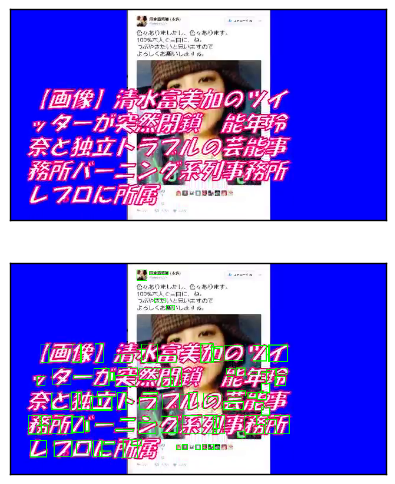

In [9]:
text.plot(data1[150])

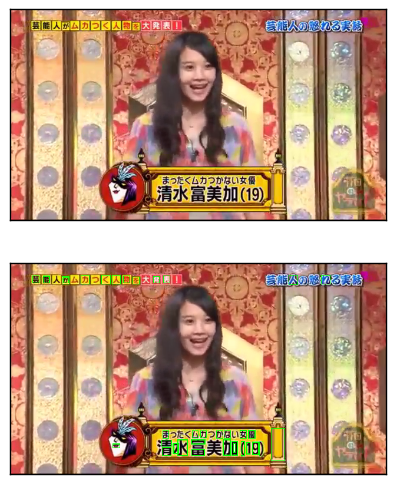

In [10]:
text.plot(data2[200])

## `data1` 平均出現的文字較多，可能是滾字影片

In [11]:
np.average([text.region_number(data1[i])
            for i in np.linspace(0, len(data1), 100, endpoint=False, dtype=int)])

421.14999999999998

In [12]:
np.average([text.region_number(data2[i])
            for i in np.linspace(0, len(data2), 100, endpoint=False, dtype=int)])

88.560000000000002